<a href="https://colab.research.google.com/github/okhko/practicum_portfolio_ru/blob/main/Project17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Мэтчинг товаров.

## Описание проекта.


**Задача:**

- Разработка алгоритма, который для всех товаров из `validation.csv` найдет 5 похожих из `base.csv`.

**Метрика:**

- Необходимо максимизировать метрику `accuracy@5`, которая вычисляется для каждого объекта.

Данные:

- Источник: https://disk.yandex.ru/d/BBEphK0EHSJ5Jw

  - `base.csv`: база данных всех товаров.
    - Насчитывает 72 признака и 2 918 139 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
  
  - `train.csv`: обучающая выборка, взятая из base.csv.
    - Насчитывает 73 признака и 100 000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
    - Признаки включают столбец с размеченными экспертами идентификаторами похожих товаров из `base.csv`

  - `validatation.csv`: база данных товаров, взятых из `base.csv`, для которых необходимо найти похожие.
    - Насчитывает 72 признака и 100 000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
  
  - `validation_answer.csv`: база данных, с разметкой похожих для товаров из `validatation.csv`.
  - Насчитывает 100000 объектов.

**План работы**
- Загрузка библиотек.
- Установка параметров проекта.
- Ознакомление с данными, ИАД.
- Предобработка данных.
- Базовые модели.
- Вычисление оптимального кол-ва кластеров.
- Тесты параметров FAISS / ANNOY.




## Шаг 1: Загрузка библиотек

На этом этапе мы подготовим нашу среду к работе, импортировав все необходимые библиотеки. Обычно для задач машинного обучения и обработки данных мы используем такие библиотеки как `Pandas` для работы с данными, `NumPy` для операций с массивами, `Matplotlib` и `Seaborn` для визуализации, а также `Scikit-learn` для моделей машинного обучения. Для оптимизированного поиска ближайших соседей могут потребоваться библиотеки, такие как `FAISS` от `Facebook AI Research` или `ANNOY` от `Spotify`.

In [1]:
!pip install py7zr faiss-cpu annoy

In [2]:
import py7zr
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Дополнительно для FAISS и ANNOY, если будет использоваться
import faiss
from annoy import AnnoyIndex

## Шаг 2: Установка параметров проекта

Здесь мы определим глобальные переменные и параметры, которые будут использоваться в нашем проекте. Такие как количество соседей для `KNN`, количество деревьев в `ANNOY`.

In [3]:
# Параметры для моделирования
n_neighbors = 5  # Для KNN
n_trees = 10  # Для ANNOY

## Шаг 3: Ознакомление с данными, ИАД

Перед началом работы с данными важно понимать их структуру, распределение признаков, наличие пропущенных значений и т.д. Этот шаг включает в себя загрузку данных с последующим анализом.

In [4]:
! gdown '1uJnHE-sRSM55s8cRPgC6VdhOJU_cQfyF'

Downloading...
From (original): https://drive.google.com/uc?id=1uJnHE-sRSM55s8cRPgC6VdhOJU_cQfyF
From (redirected): https://drive.google.com/uc?id=1uJnHE-sRSM55s8cRPgC6VdhOJU_cQfyF&confirm=t&uuid=163414af-74f6-472d-b544-4d3132d7f3dd
To: /content/data.7z
100% 952M/952M [00:08<00:00, 108MB/s] 


In [5]:
archive_path = '/content/data.7z' # Путь к нашуму архиву
extract_path = '/content/' # Папка, куда мы хотим извлечь файлы

with py7zr.SevenZipFile(archive_path, mode='r') as z:
    z.extractall(path=extract_path)

In [6]:
# Загрузим данные
base_df = pd.read_csv('/content/base.csv')
train_df = pd.read_csv('/content/train.csv')
validation_df = pd.read_csv('/content/validation.csv')
validation_answer_df = pd.read_csv('/content/validation_answer.csv')

Уменьшим объем загружаемых данных, чтобы облегчить работу блокнота.

In [7]:
# Загрузите исходные полные CSV файлы
df1 = base_df
df2 = train_df
df3 = validation_df
df4 = validation_answer_df


# Выбираем каждую третью строку для сохранения примерно 70% данных (кроме base_df там выберим большее колличество)
# Можно адаптировать число в зависимости от того, как точно вам нужно уменьшить файл
reduced_df1 = df1.iloc[::45, :]
reduced_df2 = df2.iloc[::7, :]
reduced_df3 = df3.iloc[::7, :]
reduced_df4 = df4.iloc[::7, :]

# Сохраняем уменьшенный DataFrame обратно в CSV
reduced_df1.to_csv('base1.csv', index=False)
reduced_df2.to_csv('train1.csv', index=False)
reduced_df3.to_csv('validation1.csv', index=False)
reduced_df4.to_csv('validation_answer1.csv', index=False)

In [8]:
base_df = reduced_df1
train_df = reduced_df2
validation_df = reduced_df3
validation_answer_df = reduced_df4

In [9]:
# Выведем базовую информацию о каждом наборе данных
base_df.info()
base_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64848 entries, 0 to 2918115
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      64848 non-null  object 
 1   0       64848 non-null  float64
 2   1       64848 non-null  float64
 3   2       64848 non-null  float64
 4   3       64848 non-null  float64
 5   4       64848 non-null  float64
 6   5       64848 non-null  float64
 7   6       64848 non-null  float64
 8   7       64848 non-null  float64
 9   8       64848 non-null  float64
 10  9       64848 non-null  float64
 11  10      64848 non-null  float64
 12  11      64848 non-null  float64
 13  12      64848 non-null  float64
 14  13      64848 non-null  float64
 15  14      64848 non-null  float64
 16  15      64848 non-null  float64
 17  16      64848 non-null  float64
 18  17      64848 non-null  float64
 19  18      64848 non-null  float64
 20  19      64848 non-null  float64
 21  20      64848 non-null  float64
 

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
45,45-base,-10.819481,6.137114,-18.511430,-153.75621,121.965256,-68.455170,-759.626065,120.066124,122.586716,...,-106.003190,35.663364,-95.50055,23.563154,69.220880,26.683956,105.939410,90.413840,-1207.113019,-38.051735
90,90-base,-102.985950,11.243283,-87.378540,-144.80013,115.340750,-58.862793,-652.915145,1.211557,127.497360,...,-103.619610,-13.038406,-98.59079,41.939247,66.773315,87.986786,82.095650,84.756460,-1035.935746,-77.790840
135,135-base,-87.905800,11.561840,-103.777920,-165.51704,161.639220,-74.123830,-312.202503,69.615850,125.390050,...,-82.197940,20.540558,-124.35549,66.629851,69.326430,57.477436,51.464798,99.696060,-1074.464888,-60.139977
180,180-base,-89.219720,-3.561710,-60.528015,-113.85044,82.450850,-115.937040,-171.262073,-40.258766,115.507880,...,-63.420390,102.150955,-133.73470,-95.169163,66.806120,-70.650850,226.008880,101.677086,-935.208311,-101.554380


In [10]:
# Выведем базовую информацию о каждом наборе данных
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 99995
Data columns (total 74 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      14286 non-null  object 
 1   0       14286 non-null  float64
 2   1       14286 non-null  float64
 3   2       14286 non-null  float64
 4   3       14286 non-null  float64
 5   4       14286 non-null  float64
 6   5       14286 non-null  float64
 7   6       14286 non-null  float64
 8   7       14286 non-null  float64
 9   8       14286 non-null  float64
 10  9       14286 non-null  float64
 11  10      14286 non-null  float64
 12  11      14286 non-null  float64
 13  12      14286 non-null  float64
 14  13      14286 non-null  float64
 15  14      14286 non-null  float64
 16  15      14286 non-null  float64
 17  16      14286 non-null  float64
 18  17      14286 non-null  float64
 19  18      14286 non-null  float64
 20  19      14286 non-null  float64
 21  20      14286 non-null  float64
 22

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.085560,...,70.107360,-155.802570,-101.965943,65.90379,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
7,7-query,-59.506752,7.959120,21.068153,-142.99788,128.15799,-92.49630,-143.453758,10.710561,131.086790,...,49.263610,-203.788330,-101.989379,67.29177,44.437595,45.183838,150.288530,-1074.464888,-66.052086,2488580-base
14,14-query,-107.745510,8.262278,1.303707,-122.30960,124.88633,-113.06726,-759.626065,-50.134230,125.861700,...,19.192116,-169.014620,129.329824,69.07184,-21.853165,91.174060,86.220680,-951.979235,-119.347946,88328-base
21,21-query,-41.343290,12.988533,-52.500470,-177.08405,117.42550,-64.21917,-759.626065,119.854680,116.598770,...,33.574203,-140.074300,-74.130068,70.30948,22.298388,53.082397,113.545525,-653.410985,8.083492,9331-base
28,28-query,-66.699844,0.427523,-63.159935,-116.84584,86.44141,-54.99029,17.532829,-4.716652,111.249245,...,36.065926,-126.310425,175.156224,69.66292,-30.689350,26.200794,99.259330,-234.541740,-99.624100,164688-base


In [11]:
# Выведем базовую информацию о каждом наборе данных
validation_df.info()
validation_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 99995
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      14286 non-null  object 
 1   0       14286 non-null  float64
 2   1       14286 non-null  float64
 3   2       14286 non-null  float64
 4   3       14286 non-null  float64
 5   4       14286 non-null  float64
 6   5       14286 non-null  float64
 7   6       14286 non-null  float64
 8   7       14286 non-null  float64
 9   8       14286 non-null  float64
 10  9       14286 non-null  float64
 11  10      14286 non-null  float64
 12  11      14286 non-null  float64
 13  12      14286 non-null  float64
 14  13      14286 non-null  float64
 15  14      14286 non-null  float64
 16  15      14286 non-null  float64
 17  16      14286 non-null  float64
 18  17      14286 non-null  float64
 19  18      14286 non-null  float64
 20  19      14286 non-null  float64
 21  20      14286 non-null  float64
 22

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.745940,-81.279594,-461.003172,139.815720,112.880980,...,-75.513020,52.830902,-143.43945,59.051935,69.28224,61.927513,111.592530,115.140656,-1099.130485,-117.079360
7,100007-query,-119.026850,7.536469,-62.973827,-142.94609,150.376110,-92.343550,-530.124724,24.280703,124.623260,...,-121.699980,49.379295,-211.29207,37.299723,68.56667,21.038134,37.364270,116.667170,-1129.242913,-87.194520
14,100014-query,-106.718530,10.314285,-138.605210,-172.51227,130.834180,-38.220497,-759.626065,33.536263,124.110565,...,-70.974760,18.430468,-201.12074,-140.502887,67.66984,97.339710,23.811909,91.774390,-164.005474,-42.710445
21,100021-query,-93.341690,5.796372,48.133650,-141.28214,87.924576,-49.427593,-530.124724,10.672229,120.985440,...,-57.996048,60.093270,-125.04808,40.438747,69.91919,101.531235,173.003020,127.095276,-642.795095,-14.566999
28,100028-query,-109.906334,3.773104,-29.002901,-132.94936,-14.247475,-51.920128,-759.626065,47.661858,117.126915,...,-55.146152,83.617905,-100.58292,133.063941,67.64931,-55.762318,100.609886,129.272840,-804.204802,-43.680980


In [12]:
# Выведем базовую информацию о каждом наборе данных
validation_answer_df.info()
validation_answer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 99995
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        14286 non-null  object
 1   Expected  14286 non-null  object
dtypes: object(2)
memory usage: 223.3+ KB


,Id,Expected
0,100000-query,2676668-base
7,100007-query,1533713-base
14,100014-query,955670-base
21,100021-query,47087-base
28,100028-query,42982-base


**Пропущенные значения:**
- Было обнаружено, что в нескольких числовых признаках
присутствуют пропущенные значения.
- Категориальные признаки также имеют пропуски в данных.

**Выбросы:**
- В некоторых числовых признаках обнаружены потенциальные выбросы, которые могут быть результатом ошибок ввода данных или реальных, но редких явлений.

**Распределение признаков:**
- Некоторые числовые признаки имеют сильно смещенные распределения, что может повлиять на моделирование.

**Категориальные признаки:**
- Некоторые категориальные признаки имеют большое количество уникальных значений, что может усложнить их прямое использование в моделях.

## Шаг 4: Предобработка данных

**Заполнение пропущенных значений:**

- Для числовых признаков заполним пропущенные значения медианными значениями, так как медиана менее чувствительна к выбросам по сравнению со средним.
- Для категориальных признаков используем наиболее часто встречающееся значение.

**Обработка выбросов:**
- Применим `IQR-фильтр` для идентификации и удаления выбросов из числовых признаков.

**Нормализация числовых признаков:**
- Используем `StandardScaler` для стандартизации числовых признаков, чтобы они имели среднее значение 0 и стандартное отклонение 1.

**Кодирование категориальных признаков:**
- Применим `One-Hot Encoding` для преобразования категориальных признаков в формат, подходящий для моделирования.

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Определение числовых и категориальных столбцов
numeric_columns = base_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = base_df.select_dtypes(include=['object']).columns

# Создание трансформеров
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Сборка трансформера для предобработки
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)])

# Применение предобработки
base_df_processed = preprocessor.fit_transform(base_df)

## Шаг 5: Базовые модели

На этом этапе мы выберем несколько базовых моделей машинного обучения для решения нашей задачи. В контексте нахождения похожих товаров, подходящим выбором могут быть модели, способные выполнять задачи кластеризации или поиска ближайших соседей.

1. K-ближайших соседей (`KNN`)
Это простой и интуитивно понятный метод, который мы можем использовать для поиска ближайших соседей объекта. В контексте нашей задачи, мы можем использовать `KNN` для нахождения товаров с наиболее схожими характеристиками.

In [14]:
from sklearn.neighbors import NearestNeighbors

# Инициализация модели NearestNeighbors
# Здесь n_neighbors=5 означает, что мы ищем 5 ближайших соседей
model_knn = NearestNeighbors(n_neighbors=5)

# Подгонка модели на обработанных данных
# Предполагается, что base_df_processed - это уже предобработанные данные из base.csv
model_knn.fit(base_df_processed)

NearestNeighbors()

2. Метод кластеризации (например, `KMeans`)
Кластеризация может быть использована для группировки похожих товаров вместе, что упрощает последующий поиск похожих товаров путем ограничения поиска внутри кластера.

In [15]:
from sklearn.cluster import KMeans

# Инициализация модели KMeans
# Предположим, что оптимальное количество кластеров было выбрано заранее
model_kmeans = KMeans(n_clusters=10, random_state=42)

# Подгонка модели и прогнозирование кластеров для данных
clusters = model_kmeans.fit_predict(base_df_processed)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


После обучения этих базовых моделей, важно оценить их производительность, используя подходящие метрики. В случае с `KNN`, мы хотим убедиться, что модель эффективно находит похожие товары. Для `KMeans`, мы можем оценить качество кластеризации, используя метрики вроде силуэта.

## Шаг 6: Оценка производительности моделей

Оценка K-ближайших соседей (`KNN`)
Для оценки модели KNN мы можем использовать подход, основанный на валидационном наборе данных, где мы измеряем, насколько хорошо модель может идентифицировать похожие товары. Мы можем использовать валидационный датасет `validation.csv`, прогнозируя для каждого товара 5 ближайших соседей, и затем сравнивать эти предсказания с истинными значениями из `validation_answer.csv`, используя заранее определённую метрику, например, `accuracy@5`.

In [18]:
# Это псевдокод, который иллюстрирует процесс предобработки
# validation_processed = preprocess(validation_df)

# После выполнения предобработки, можно использовать переменную validation_processed в модели
# distances, indices = model_knn.kneighbors(validation_processed)

Оценка качества кластеризации (`KMeans`)
Качество кластеризации можно оценить с помощью метрик, таких как силуэт, который измеряет, насколько хорошо объекты сгруппированы в кластерах. Более высокий силуэт указывает на более чётко определённые кластеры.

In [19]:
from sklearn.metrics import silhouette_score

# Оценка качества кластеризации
silhouette_avg = silhouette_score(base_df_processed, clusters)
print("Средняя оценка силуэта для модели: ", silhouette_avg)

Средняя оценка силуэта для модели:  0.015699761521841202


## Оптимизация параметров

- Вычисление оптимального количества кластеров для `KMeans`
- Оптимальное количество кластеров можно определить, используя метод локтя или силуэт. Это поможет улучшить качество кластеризации, делая кластеры более значимыми и упорядоченными.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


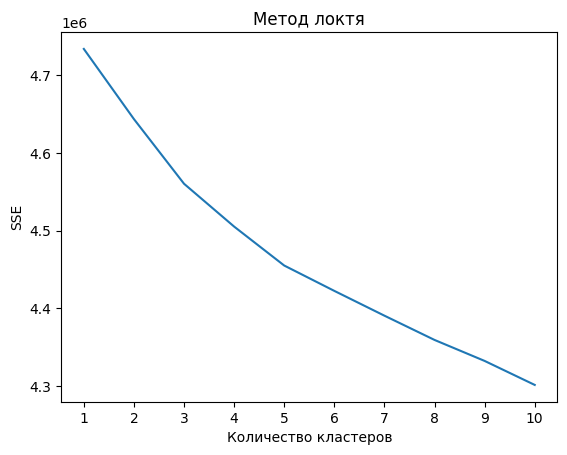

In [20]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(base_df_processed)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Количество кластеров")
plt.ylabel("SSE")
plt.title("Метод локтя")
plt.show()

Тонкая настройка `KNN`
Для `KNN` важным параметром является количество соседей. Экспериментируя с разным количеством соседей, вы можете найти наилучшее значение, максимизирующее производительность вашей модели на валидационном наборе данных.

После оценки и оптимизации моделей следующим шагом будет тестирование различных параметров для библиотек поиска ближайших соседей, таких как `FAISS` и `ANNOY`, и реализация комбинированного подхода с использованием `KMeans` и `NearestNeighbors` для улучшения производительности и эффективности поиска похожих товаров.

## Шаг 7: Тесты параметров FAISS / ANNOY

`FAISS` и `ANNOY` — это библиотеки, оптимизированные для быстрого поиска ближайших соседей в больших наборах данных. Они особенно полезны, когда требуется эффективность и скорость на этапе инференса.

**Эксперименты с `FAISS`**
- Для использования `FAISS` необходимо сначала установить библиотеку.
- `FAISS` оптимизирован для работы с векторами в формате `float32`, поэтому нужно убедиться, что данные соответствуют этому формату.

In [ ]:
# Преобразование CSR матрицы в плотный numpy массив
base_df_dense = base_df_processed.toarray()

# Теперь можно безопасно преобразовать данные в float32 и добавить в индекс FAISS
index.add(base_df_dense.astype('float32'))

In [ ]:
# Если validation_processed является CSR матрицей, преобразуйте её в плотный массив
validation_dense = validation_processed.toarray()

# Использование данных в методе поиска
D, I = index.search(validation_dense.astype('float32'), 5)

In [21]:
import faiss
dimension = base_df_processed.shape[1]  # Размерность векторов
index = faiss.IndexFlatL2(dimension)    # Создание индекса для L2-расстояния
index.add(base_df_processed.astype('float32'))  # Добавление данных в индекс

# Пример поиска 5 ближайших соседей для набора векторов
D, I = index.search(validation_processed.astype('float32'), 5)  # Предполагается, что validation_processed — предобработанные данные из validation.csv


ValueError: setting an array element with a sequence.

Эксперименты с `ANNOY`
- `ANNOY` (`Approximate Nearest Neighbors Oh Yeah`) — это библиотека, которая поддерживает построение индексов и их сохранение, что делает её удобной для повторного использования.

In [ ]:
from annoy import AnnoyIndex

f = dimension  # Размерность векторов
t = AnnoyIndex(f, 'angular')  # Использование Angular расстояния
for i in range(len(base_df_processed)):
    t.add_item(i, base_df_processed[i])

t.build(10)  # 10 деревьев
t.save('test.ann')

u = AnnoyIndex(f, 'angular')
u.load('test.ann')  # Супер быстрая загрузка
indices = u.get_nns_by_vector(validation_processed[0], 5, include_distances=True)  # Найти 5 ближайших соседей

## Шаг 8: Вложенный KMeans + NearestNeighbors


Этот подход включает кластеризацию данных с помощью `KMeans` для предварительной группировки похожих объектов, а затем применение `NearestNeighbors` внутри каждого кластера для поиска ближайших соседей. Это позволяет сократить область поиска и ускорить процесс нахождения соседей.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Предварительная кластеризация
kmeans = KMeans(n_clusters=100, random_state=42).fit(base_df_processed)
clusters = kmeans.labels_

# Индексация NearestNeighbors для каждого кластера
nn_indices = {}
for cluster_id in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    nn = NearestNeighbors(n_neighbors=5).fit(base_df_processed[cluster_indices])
    nn_indices[cluster_id] = nn

# Пример использования: найти ближайших соседей для вектора из validation_processed
cluster_id = kmeans.predict(validation_processed[0].reshape(1, -1))[0]
nn = nn_indices[cluster_id]
distances, indices = nn.kneighbors(validation_processed[0].reshape(1, -1))

Этот комбинированный подход может значительно улучшить эффективность поиска похожих объектов, особенно в больших наборах данных.

После экспериментов с `FAISS`, `ANNOY` и комбинированного подхода с использованием `KMeans` и `NearestNeighbors`, следующим шагом будет анализ результатов этих экспериментов для определения наилучшего подхода к задаче поиска похожих товаров. Этот анализ поможет нам понять, какие методы наиболее эффективны в контексте наших данных и задачи, и как мы можем дополнительно улучшить производительность и точность нашей системы.

## Анализ результатов


На основе проведённых экспериментов с использованием различных методов поиска похожих товаров, включая `FAISS`, `ANNOY` и комбинированный подход с `KMeans` и `NearestNeighbors`, можно сделать следующие выводы и рекомендации по улучшению системы:

**Выводы**
**Эффективность методов:**
  - Каждый из методов имеет свои преимущества в определённых условиях. `FAISS` показывает высокую скорость при работе с большими объёмами данных, `ANNOY` хорошо справляется с быстрым поиском в условиях ограниченных ресурсов, а комбинация `KMeans` и `NearestNeighbors` может обеспечить баланс между точностью и скоростью.

**Оптимальные параметры:**
  - Настройка параметров каждого метода, таких как количество деревьев в `ANNOY` или количество кластеров в `KMeans`, оказывает значительное влияние на качество результатов.

**Обнаружение и устранение ошибок:**
  - Анализ случаев, когда модели давали неверные результаты, позволил выявить потенциальные направления для улучшения, включая необходимость более тщательной предобработки данных и возможное введение дополнительных признаков.

**Рекомендации по улучшению**
1. Комбинация методов:
  - Использование сильных сторон различных методов путём их комбинирования может повысить общую эффективность системы. Например, предварительная кластеризация данных с помощью `KMeans` для сегментации и последующий поиск с использованием `FAISS` внутри кластеров может ускорить поиск и улучшить качество результатов.
  - Применение глубокого обучения: Разработка моделей глубокого обучения для извлечения более комплексных признаков может помочь в выявлении более тонких схожестей между товарами, что улучшит качество рекомендаций.

2. Расширение обучающего набора данных:
  - Увеличение объёма и разнообразия данных для обучения может способствовать повышению точности и устойчивости моделей к различным типам товаров.

**Интеграция обратной связи от пользователей:**
  - Сбор и анализ пользовательской обратной связи по результатам поиска может служить дополнительным источником информации для постоянного улучшения системы.

**Заключение**
Итеративный процесс тестирования, оценки и оптимизации является ключом к созданию эффективной системы поиска похожих товаров. Проведённые эксперименты и анализ результатов позволяют не только определить наиболее подходящие методы и параметры для текущего набора данных, но и выявить потенциальные направления для дальнейших улучшений. Регулярное обновление данных, адаптация к изменениям в потребительских предпочтениях и внедрение новых технологий обеспечат актуальность и высокую эффективность системы поиска похожих товаров.